<h1>Narrative Arc Sherlock Holmes</h1>

by David Siegl

In [4]:
import pandas as pd
import nltk
import os
from collections import defaultdict
from collections import Counter
import re
import string
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
nltk.download ('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/david/nltk_data...


True

<h2>Preprocessing</h2>

The complete works of Sherlock Holmes were downloaded as individual text files through this website archive https://sherlock-holm.es/.

As a first step of the preprocessing pipeline we read every text file, extract its title, remove some unnecessary lines and finally build a dictionary with the keys corresponding to the respective title and the values to each text accordingly. The created dictionary is then converted into a dataframe.

In [23]:
df_dict = defaultdict(str)
title = None

for f in os.listdir('./data/sherlock/'):
    with open('./data/sherlock/' + f, 'r') as text:
        lines = text.readlines()
        text.seek(0)
        ls = list()
        for number, line in enumerate(lines):
            if number == 4: # extracting the title of each story as a key
                title = line
                title = title.strip()
            elif number not in [4, 6] and line != "\n": # skipping unneccesary lines
                ls.append(line.strip(" "))
            
        conc_text = "".join(ls)
        conc_text = re.sub(r'[-]{10}\n([\S\s]+)', '', conc_text) # removing additional information at the bottom of the text files
        conc_text = conc_text.strip()
        df_dict[title] = conc_text

In [24]:
df_sherlock = pd.DataFrame.from_dict(df_dict, orient='index', columns=['text'])
df_sherlock.index.name = 'title'

Next we apply common preprocessing steps such as punctuation and stopwords removal as well as lemmatisation.

In [25]:
df_sherlock['text_prepro'] = df_sherlock['text'].str.lower()

In [26]:
translator = str.maketrans('', '', string.punctuation)
df_sherlock['text_prepro'] = df_sherlock['text_prepro'].apply(lambda x: x.translate(translator))

In [27]:
stopwords = nltk.corpus.stopwords.words('english')
df_sherlock['text_prepro'] = df_sherlock['text_prepro'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [28]:
df_sherlock['text_prepro_tok'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [29]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lem_text(text):
    lemmed_words = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(lemmed_words)

df_sherlock['text_lemmed'] = df_sherlock['text_prepro'].apply(lem_text)

In addition we also have to segment each text into 5 parts of equal length in order to compute local values for certain points in narrative time which can then be compared according to the notion of a narrative arc. Here we opt for a value of 5 segments because it firstly corresponds to the traditional notion of the dramatic climactic progression of rise and fall and is secondly also supported by the relevant literature which has been consulted beforehand.

In [30]:
def segment_text (text):
    segment_length = len(text) // 5
    segments = [text[i:i+segment_length] for i in range(0, len(text), segment_length)]
    return segments[:5]

df_sherlock['segments'] = df_sherlock['text_prepro'].apply(segment_text)

df_sherlock_segments = df_sherlock.explode('segments')

In [31]:
df_sherlock['segments_vader'] = df_sherlock['text'].apply(segment_text)

df_sherlock_segments_vader = df_sherlock.explode('segments_vader')

In [32]:
values = list(range(1, 6)) * ((len(df_sherlock_segments) // 5) + 1)

df_sherlock_segments['segment_num'] = values[:len(df_sherlock_segments)]

In [33]:
df_sherlock_segments_vader['segment_num'] = values[:len(df_sherlock_segments)]

In [20]:
df_sherlock_segments['segments'] = df_sherlock_segments['segments'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [21]:
df_sherlock_segments.reset_index(inplace=True)

<h2> EDA </h2>

In order to obtain a better understanding on the data we first do some basic EDA such as for example the extraction of the distribution of text length throughout the whole dataset which will help with normalisation further down the pipeline.

In [42]:
df_sherlock['word_counts'] = df_sherlock['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='word_counts', ylabel='Count'>

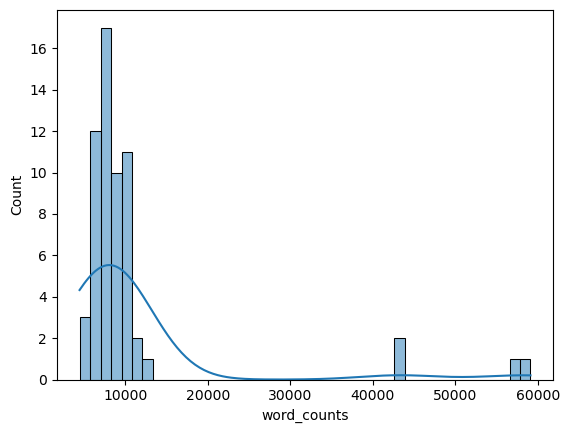

In [43]:
sns.histplot(df_sherlock, x='word_counts', kde=True)

This basic histogram already displays a considerable skew of the data towards shorter stories of around 5000 words, which can be mainly explained by the fact that the original Sherlock Holmes stories were mainly published as a series of short stories within the literature magazine 'The Strand'.

In [44]:
df_sherlock.nlargest(4, 'word_counts')[['word_counts']]

,word_counts
title,
THE HOUND OF THE BASKERVILLES,59108
THE VALLEY OF FEAR,57551
A STUDY IN SCARLET,43379
THE SIGN OF THE FOUR,42998


In [45]:
df_sherlock["avg_sent_len"] = df_sherlock["text"].map(lambda x: np.mean([len(w.split()) for w in nltk.tokenize.sent_tokenize(x)]))

<Axes: xlabel='avg_sent_len', ylabel='Count'>

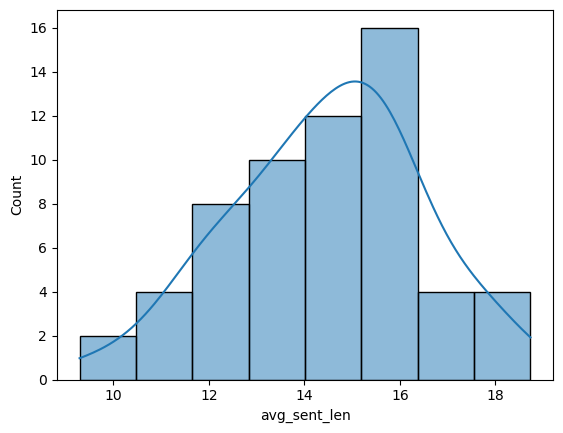

In [46]:
sns.histplot(df_sherlock, x='avg_sent_len', kde=True)

The texts with the most words are unsurpringly the short novels within the corpus.

In [47]:
all_text = ' '.join(df_sherlock['text_lemmed'])
all_text = nltk.word_tokenize(all_text)
 
word_counts = Counter(all_text)
most_common = word_counts.most_common(25)

<Axes: >

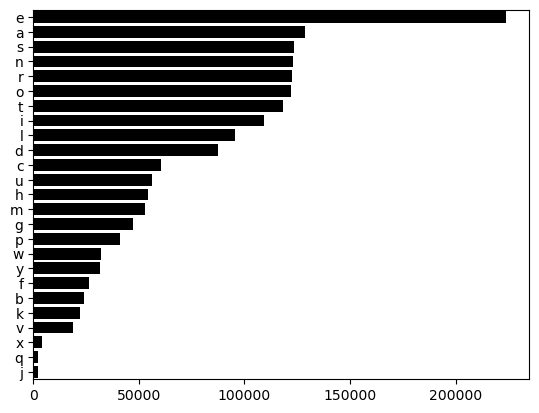

In [48]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words, color='black')

The extraction of the most common words across the stories of Sherlock Holmes do not provide too much of a surprise at a first glance: The frequent mentioning of the two protagonists names (Holmes and Watson) are to be expected. Furthermore the frequent usage of basic verbs might already suggest the establishing of a certain narrative tension throughout a given story. Last but not least high occurence of nouns such as 'room', 'door' or 'night' point towards more mysterious semantics, which can be attributed to the genre conventions of crime/detective fiction.

In [49]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sherlock['text_prepro'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

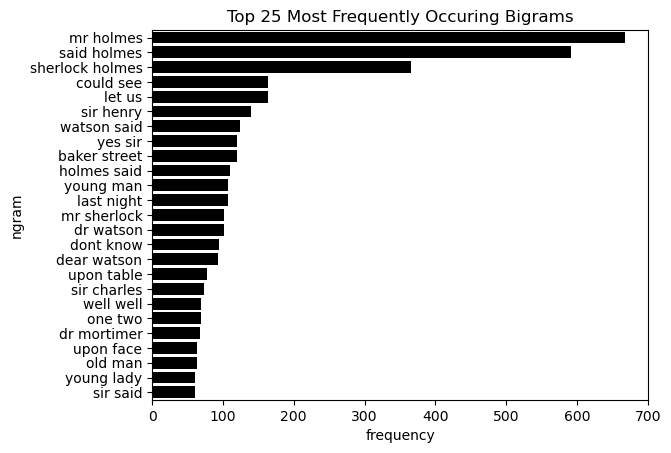

In [50]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Bigrams')
plt.show()

In [51]:
cv2 = CountVectorizer(ngram_range=(3,3))
trigrams = cv2.fit_transform(df_sherlock['text_prepro'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv2.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

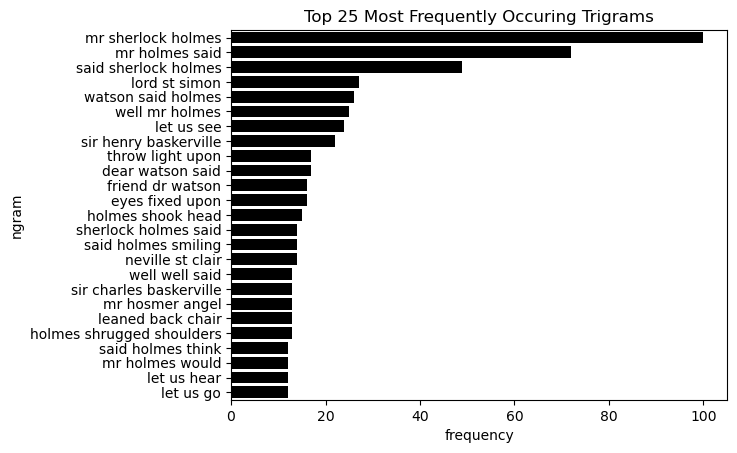

In [52]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Trigrams')
plt.show()

<h2> Narrative arc </h2>

In [28]:
keywords_dict = pd.read_csv('./data/AON Dict - Without Overlaps.dic', sep='\t')

<h2> Temporal usage </h2>

In [13]:
def pos_tag_text(text):
    pos_tags = nltk.pos_tag(text)
    return pos_tags

df_sherlock_segments['text_pos'] = df_sherlock_segments['segments'].apply(pos_tag_text)

In [14]:
def tense_counts(pos_tags):
    past_count = 0
    present_count = 0
    future_count = 0
    
    for word, tag in pos_tags[1::2]:
        if tag.startswith('VBD'):
            past_count += 1
        elif tag.startswith('VB'):
            present_count += 1
        elif tag.startswith('MD'):
            future_count += 1
    
    counts = {'past_count': past_count,
              'present_count': present_count,
              'future_count': future_count}
    
    return pd.Series(counts)        
    
    
df_sherlock_segments[['past_count', 'present_count', 'future_count']] = df_sherlock_segments['text_pos'].apply(tense_counts)

In [15]:
def min_max_scale_column(df, new_column_name, col_to_norm, col_length):
    df['tf'] = df[col_to_norm] / len(df[col_length])
    df['idf'] = math.log(60) / (df[col_to_norm] != 0).value_counts()[True]
    df[new_column_name] = df['tf'] * df['idf']
    scaler = MinMaxScaler()
    df[new_column_name] = scaler.fit_transform(df[[new_column_name]])
    return df

df_sherlock_segments = min_max_scale_column(df_sherlock_segments, 'future_count_norm', 'future_count', 'text_prepro_tok')

df_sherlock_segments = min_max_scale_column(df_sherlock_segments, 'past_count_norm', 'past_count', 'text_prepro_tok')

df_sherlock_segments = min_max_scale_column(df_sherlock_segments, 'present_count_norm', 'present_count', 'text_prepro_tok')

In [16]:
df_sherlock_pivot = df_sherlock_segments[['title', 'segment_num', 'future_count_norm', 'past_count_norm', 'present_count_norm']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

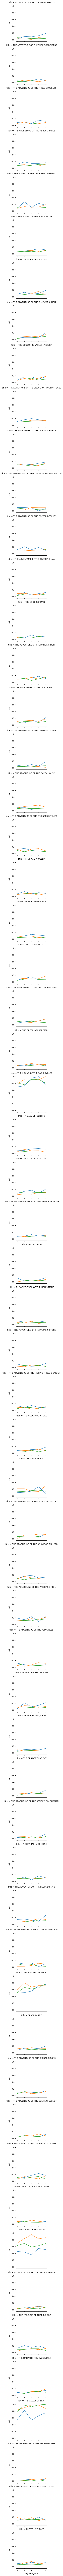

In [17]:
fg = sns.FacetGrid(df_sherlock_pivot, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

In [18]:
summary_stats_tenses = df_sherlock_segments[['segment_num', 'present_count_norm', 'future_count_norm', 'past_count_norm']].groupby('segment_num').agg(['mean', 'std'])

print(summary_stats_tenses)

            present_count_norm           future_count_norm             
                          mean       std              mean       std   
segment_num                                                            
1                     0.107403  0.162452          0.115580  0.123267  \
2                     0.119680  0.180813          0.140217  0.145607   
3                     0.121763  0.179950          0.138768  0.143329   
4                     0.124442  0.188363          0.148007  0.170683   
5                     0.126488  0.190697          0.167210  0.151291   

            past_count_norm            
                       mean       std  
segment_num                            
1                  0.115883  0.170803  
2                  0.137678  0.199644  
3                  0.144373  0.205711  
4                  0.140883  0.197519  
5                  0.158689  0.198392  


<Axes: xlabel='segment_num', ylabel='value'>

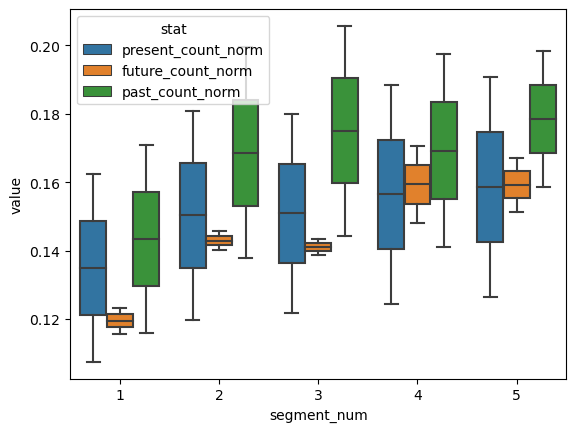

In [19]:
summary_stats_tenses = summary_stats_tenses.reset_index()
summary_stats_tenses = pd.melt(summary_stats_tenses, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_tenses = summary_stats_tenses.drop(index=summary_stats_tenses[(summary_stats_tenses['stat'] == 'level_0') | summary_stats_tenses['stat'] =='index'].index)

sns.boxplot(data = summary_stats_tenses, x='segment_num', y='value', hue='stat')

In [20]:
def group_df(df, value):
    ls = []
    for i in range(1, df['segment_num'].nunique() + 1):
        ls.append(df[df['segment_num'] == i][value])
    return ls

In [21]:
ls_anova = group_df(df_sherlock_segments, 'past_count_norm')

fvalue_past, pvalue_past = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for past tense usage (fvalue, pvalue): {}, {}'.format(fvalue_past, pvalue_past))

Results for ANOVA test for past tense usage (fvalue, pvalue): 0.37751493714807044, 0.8246374148032906


In [22]:
ls_anova = group_df(df_sherlock_segments, 'present_count_norm')

fvalue_present, pvalue_present = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for present tense usage (fvalue, pvalue): {}, {}'.format(fvalue_present, pvalue_present))

Results for ANOVA test for present tense usage (fvalue, pvalue): 0.1027353576082088, 0.981478916854257


In [24]:
ls_anova = group_df(df_sherlock_segments, 'future_count_norm')

fvalue_future, pvalue_future = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for future tense usage (fvalue, pvalue): {}, {}'.format(fvalue_future, pvalue_future))

Results for ANOVA test for future tense usage (fvalue, pvalue): 0.9521425250233858, 0.43417726959359293


<Axes: xlabel='tense', ylabel='value'>

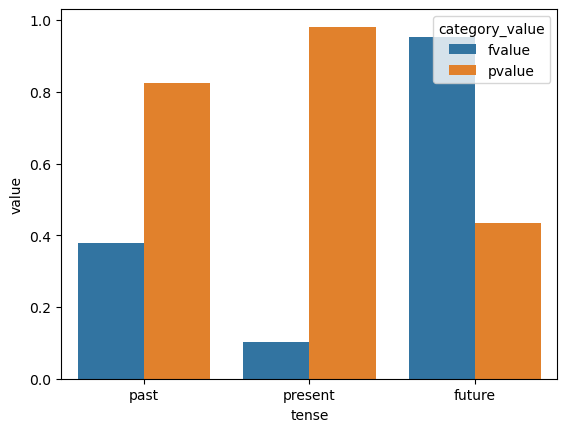

In [37]:
col1 = [fvalue_past, fvalue_present, fvalue_future, pvalue_past, pvalue_present, pvalue_future]
col2 = ['past', 'present', 'future', 'past', 'present', 'future']
col3 = ['fvalue', 'fvalue', 'fvalue', 'pvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'tense': col2, 'category_value': col3}

df_anova_tenses = pd.DataFrame(df_dict)

sns.barplot(data = df_anova_tenses, x='tense', y ='value', hue = 'category_value')

<h2> Emotion Analysis </h2>

In [7]:
vader = nltk.sentiment.vader.SentimentIntensityAnalyzer()

In [34]:
df_sherlock_segments_vader['sentiment_scores'] = df_sherlock_segments_vader['segments_vader'].apply(lambda x : vader.polarity_scores(x))

In [35]:
df_sherlock_segments_vader["compound"] = df_sherlock_segments_vader["sentiment_scores"].apply(lambda x: x["compound"])